In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

## Collect MNIST Dataset as Arrays

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

## STEP 1:  Preprocess Dataset

In [3]:
import ktrain
from ktrain import vision as vis

In [4]:
data_aug = vis.get_data_aug(  rotation_range=15,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1)
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [5]:
(trn, val, preproc) = vis.images_from_array(x_train, y_train, 
                                            validation_data=None,
                                            val_pct=0.1,
                                            random_state=42,
                                            data_aug=data_aug,
                                            classes=classes)

## STEP 2: Load Model and Wrap in `Learner`

In [6]:
# Using a LeNet-style classifier
model = vis.image_classifier('default_cnn', trn, val)

Is Multi-Label? False
default_cnn model created.


In [7]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

## STEP 3: Find Learning Rate

simulating training for different learning rates... this may take a few moments...
Train for 421 steps
Epoch 1/3
421/421 [==============================] - 15s 35ms/step - loss: 2.9301 - accuracy: 0.1410
Epoch 2/3
421/421 [==============================] - 14s 33ms/step - loss: 0.8085 - accuracy: 0.7409
Epoch 3/3
197/421 [=============>................] - ETA: 7s - loss: 0.4978 - accuracy: 0.8852

done.
Visually inspect loss plot and select learning rate associated with falling loss


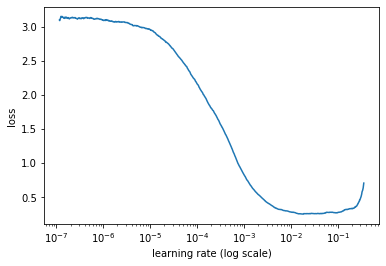

In [8]:
learner.lr_find(show_plot=True, max_epochs=3)

## STEP 3: Train Model

We only train for three epochs for demonstration purposes.

In [9]:
learner.fit_onecycle(1e-3, 3)



begin training using onecycle policy with max lr of 0.001...
Train for 422 steps, validate for 188 steps
Epoch 1/3
422/422 [==============================] - 15s 35ms/step - loss: 0.8279 - accuracy: 0.7384 - val_loss: 0.0681 - val_accuracy: 0.9802
Epoch 2/3
422/422 [==============================] - 15s 35ms/step - loss: 0.1559 - accuracy: 0.9532 - val_loss: 0.0654 - val_accuracy: 0.9798
Epoch 3/3
422/422 [==============================] - 14s 34ms/step - loss: 0.0990 - accuracy: 0.9702 - val_loss: 0.0316 - val_accuracy: 0.9905


In [10]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

        zero       1.00      0.99      0.99       624
         one       1.00      1.00      1.00       654
         two       0.99      0.99      0.99       572
       three       0.99      0.99      0.99       589
        four       0.99      0.99      0.99       580
        five       1.00      0.99      0.99       551
         six       0.99      0.99      0.99       580
       seven       0.99      0.99      0.99       633
       eight       0.98      0.98      0.98       585
        nine       0.99      0.99      0.99       632

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



array([[618,   0,   0,   0,   0,   0,   2,   0,   4,   0],
       [  0, 652,   0,   1,   0,   0,   0,   0,   0,   1],
       [  0,   1, 566,   0,   0,   0,   0,   1,   4,   0],
       [  0,   0,   2, 586,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0, 574,   0,   0,   1,   0,   5],
       [  1,   0,   0,   2,   0, 545,   1,   0,   1,   1],
       [  0,   0,   1,   1,   1,   0, 576,   0,   1,   0],
       [  0,   1,   3,   0,   1,   0,   0, 626,   2,   0],
       [  1,   0,   2,   0,   3,   1,   0,   1, 576,   1],
       [  0,   0,   0,   0,   1,   1,   0,   5,   1, 624]])

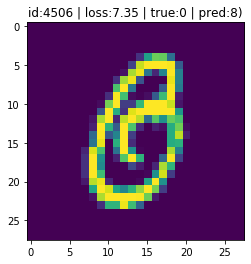

In [11]:
learner.view_top_losses(n=1)

## Make Predictions

In [12]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [13]:
predictor.predict(x_test[0:1])[0]

'seven'

In [14]:
np.argmax(predictor.predict(x_test[0:1], return_proba=True)[0])

7

In [15]:
predictor.save('/tmp/my_mnist')

In [16]:
p = ktrain.load_predictor('/tmp/my_mnist')

In [17]:
p.predict(x_test[0:1])[0]

'seven'

In [18]:
predictions = p.predict(x_test)

In [19]:
import pandas as pd
df = pd.DataFrame(zip(predictions, y_test), columns=['Predicted', 'Actual'])
df.head()

,Predicted,Actual
0,seven,7
1,two,2
2,one,1
3,zero,0
4,four,4
